# 1.Color Histogram
* Bất biến đối với:
  + tịnh tiến
  + quay quanh trục quan sát
* Chỉ thay đổi chậm khi:
  + quay quanh các trục khác
  + bị che khuất
  + thay đổi khoảng cách tới vật thể <br>
**Vì vậy,** một vật thể 3D có thể được biểu diễn đầy đủ chỉ bằng một số ít histogram, tương ứng với một tập các góc nhìn chuẩn.
* histogram của các vật thể khác nhau có thể khác nhau rất rõ rệt <br>
=> Color histogram là một biểu diễn phù hợp cho bài toán nhận diện vật thể


---


Mặc dù histogram sử dụng phép chia bin rời rạc (all-or-nothing),
nhưng trong thực tế các bề mặt vật thể thường gồm những vùng màu lớn.
Do ảnh hưởng của shading và nhiễu cảm biến, các vùng này trải rộng
trong không gian màu và chiếm nhiều bin lân cận.

Vì vậy, khi so khớp histogram của cùng một vật thể,
Histogram Intersection vẫn cho giá trị cao,
ngay cả khi các pixel không trùng khớp từng điểm.
Điều này giải thích vì sao histogram đơn giản vẫn hoạt động hiệu quả
trong nhận diện vật thể.


In [ ]:
!pip install kaggle


In [ ]:
# Tai file kaggle.json ve roi upload len
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -q fashion-product-images-small.zip -d /content/datasets

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 97% 551M/565M [00:06<00:00, 142MB/s]
100% 565M/565M [00:06<00:00, 87.3MB/s]


In [ ]:
import cv2
import numpy as np
import imutils

In [ ]:
class ColorDescriptor():
  def __init__(self, bins):
    self.bins = bins

  def describe(self,img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    features =[]

    (h, w) = img.shape[:2]
    (cY,cX) = int(0.5 * h), int(0.5 *w)
    """chia anh thanh cac vung de luoc do khong
    bi anh huong boi anh tong the khi co nhieu
    mau trong hinh -> chia thanh cac mask"""
    # (startX, endX, startY, endY)
    # top left- top right - bot right- bot left
    segments = [(0 ,cX ,0 ,cY), (cX, w ,0 ,cY),
                (cX ,w ,cY ,h), (0, cX, cY, h)]

    (axisX, axisY) = int( w*0.75 //2), int(h *0.75 //2)
    ellipMask = np.zeros(img.shape[:2], dtype= 'uint8')
    cv2.ellipse(ellipMask, (cX,cY),(axisX, axisY),0,0,360, 255, -1)

    #Tao mask
    for (startX, endX, startY, endY) in segments:
      cornerMask = np.zeros(img.shape[:2], dtype ='uint8')
      cv2.rectangle(cornerMask, (startX, startY),(endX, endY),255, -1)
      cornerMask = cv2.subtract(cornerMask, ellipMask)
      # Tinh hist voi mask
      hist = self.histogram(img, cornerMask)
      features.extend(hist)

    hist = self.histogram(img,ellipMask)
    features.extend(hist)
    return features

  def histogram(self, img, mask):
    hist = cv2.calcHist( [img], [0,1,2], mask, self.bins, [0,180,0,256,0,256])
    # kiem tra ver cua cv2
    if imutils.is_cv2():
      hist = cv2.normalize(hist).flatten()
    else:
      hist = cv2.normalize(hist, hist).flatten()
    # neu tinh histogram intersection thi de dong duoi
    hist = hist / np.sum(hist)
    return hist

In [ ]:
import glob

In [ ]:
args = {
    "dataset": "/content/datasets/images",  # Thu muc chua dataset
    "index": "./index.csv",
}

# Khoi tao ColorDescriptor
cd = ColorDescriptor((8,12,3))

output= open(args["index"],"w")
for imgPath in glob.glob(args['dataset']+'/*.jpg'):
  imgId = imgPath[imgPath.rfind("/") +1:]
  img = cv2.imread(imgPath)

  features = cd.describe(img)
  features =[ str(f) for f in features]
  output.write('%s, %s\n'%(imgId, ",".join(features)))

output.close()

In [ ]:
!wc -l /content/index.csv


44441 /content/index.csv


# 2. Histogram intersection
* Histogram Intersection đo phần màu chắc chắn trùng nhau giữa ảnh và model,
không bị background phá, không cần segmentation.


In [ ]:
import csv
import numpy as np
class Search():
  def __init__(self, indexPath):
    self.indexPath = indexPath

  def search(self,queryFeatures, limit =10):
    results ={}
    with open(self.indexPath) as f:
      reader = csv.reader(f)

      for row in reader:
        features = [float(x) for x in row[1:]]
        d = self.histogram_intersection(features, queryFeatures)

        results[row[0]] = d
      f.close()
    # dung hist_intersection reverse=True con lai = False
    results = sorted([(v, k) for (k,v) in results.items()],reverse=True)
    return results[:limit]

  def chi_squared_distance(self, hsv1, hsv2, eps= 1e-10):
    d = 0.5* np.sum([((a - b)**2) /(a+b+eps)
                      for (a,b) in zip(hsv1, hsv2)])

    return d

  def histogram_intersection(self, hsv1, hsv2):
    d = np.sum([min(a,b) for (a,b) in zip(hsv1, hsv2)])

    return d

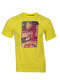

4.9999999603


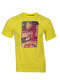

4.132638833675177


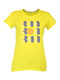

4.108438933987931


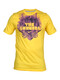

4.0665069654538994


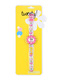

4.03821090865672


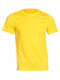

3.9637674553232167


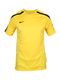

3.842102664261577


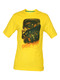

3.825489745830498


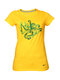

3.818456189155527


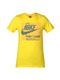

3.7791278339631384


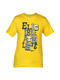

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
query = cv2.imread('/content/datasets/images/10013.jpg')
queryFeatures = cd.describe(query)
search = Search('/content/index.csv')
results = search.search(queryFeatures)
cv2_imshow(query)
for (score, resultId) in results:
  result = cv2.imread('/content/datasets/images/'+resultId)
  print(score)
  cv2_imshow(result)


#FAISS